In [11]:
import momepy
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point, box, MultiLineString
from shapely.ops import unary_union
import planetary_computer
import pystac_client
import dask.dataframe
import dask_geopandas as dgd
import dask.distributed
import deltalake
import shapely.geometry
import mercantile
import rasterio
import rasterio.mask
from rasterio.plot import show
from shapely.geometry import shape, Polygon, mapping, box, LineString
from rasterio.features import shapes
import osmnx as ox
import os
from tqdm import tqdm

In [12]:
local_crs = 27700
place = "glasgow"
latlng = (-4.251846930489373, 55.86421405612109)
country = "united kingdom"
crs=4326

In [13]:
local_crs = 3414
place = "singapore"
lat = 1.28795311
lng = 103.851784
crs=4326

In [14]:
latlng = (lat, lng)

In [15]:
radius = 35 #km

In [16]:
## create directory ./out/{place} if it does not exist
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        
create_dir(f"./output/{place}")

## part 1: Find limits of cells to download

In [17]:
def create_square(center_point, distance):
    """
    Create a square polygon centered on the given point.
    The 'distance' parameter is half the side length of the square.
    """
    x, y = center_point.x, center_point.y
    return Polygon([(x - distance, y - distance),
                    (x - distance, y + distance),
                    (x + distance, y + distance),
                    (x + distance, y - distance)])

# Create a GeoSeries with the specified point
gdf = gpd.GeoSeries([Point(latlng[1], latlng[0])], crs=crs)

# The UTM zone number can be calculated from the longitude
utm_zone = int((latlng[1] + 180) / 6) + 1
# Determine the hemisphere and assign the appropriate UTM CRS
if latlng[0] >= 0:  # Northern Hemisphere
    local_utm_crs = f'EPSG:326{utm_zone:02d}'
else:  # Southern Hemisphere
    local_utm_crs = f'EPSG:327{utm_zone:02d}'
    
# Reproject to a local UTM CRS
gdf_utm = gdf.to_crs(local_utm_crs)

# Get the center point in UTM coordinates
center_point = gdf_utm[0]

# Create a square polygon centered on the point
square = create_square(center_point, radius * 1000)  # Convert km to meters

# Create a GeoSeries for the square in UTM coordinates
square_gs_utm = gpd.GeoSeries([square], crs=gdf_utm.crs)

# Reproject the square back to the original CRS
area_of_interest = square_gs_utm.to_crs(crs)

# Plotting
area_of_interest.explore()

In [18]:
# # Create a GeoDataFrame with the specified point
# gdf = gpd.GeoDataFrame(geometry=[Point(latlng[0], latlng[1])], crs=crs)

# # Reproject to a coordinate system that uses meters (UTM)
# gdf_utm = gdf.to_crs(epsg=local_crs)

# # Create a 50 km buffer around the point
# buffer = gdf_utm.buffer(10000)  # 50 km buffer

# # Reproject buffer back to original CRS
# area_of_interest = buffer.to_crs(epsg=crs)

# # Plottin
# area_of_interest.explore()



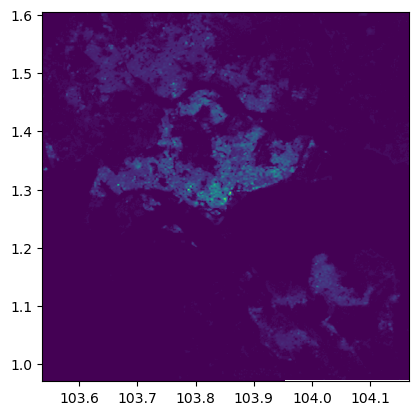

In [19]:
# Read only the portion of the GeoTIFF that intersects with the AOI

cell_polygons = []
with rasterio.open("output/built_height.tif") as src:
    # Calculate the window to read based on AOI bounds
    out_image, transformed = rasterio.mask.mask(src, area_of_interest, crop=True, filled=True)
    out_profile = src.profile.copy()
    
out_profile.update({'width': out_image.shape[2],'height': out_image.shape[1], 'transform': transformed})
with rasterio.open(f"output/{place}.tif", 'w', **out_profile) as dst:
    dst.write(out_image)
    
with rasterio.open(f"output/{place}.tif") as src:
    show(src)

In [20]:
def get_cell_polygon(x, y, transform):
    """
    Create a polygon for the given cell coordinates (x, y) using the affine transform.
    """
    tl = transform * (x, y)
    tr = transform * (x + 1, y)
    br = transform * (x + 1, y + 1)
    bl = transform * (x, y + 1)
    return Polygon([tl, tr, br, bl, tl])

In [21]:
mask = None
with rasterio.Env():
    with rasterio.open(f"output/{place}.tif") as src:
        image = src.read(1) # first band
        transform = src.transform

        # Prepare schema for shapefile
        schema = {
            'properties': [('raster_val', 'int')],
            'geometry': 'Polygon'
        }

        # with fiona.open(f"output/{place}/height_cells.shp", 'w', 
        #                 driver='ESRI Shapefile',
        #                 crs=src.crs,
        #                 schema=schema) as dst:
            
        #     # Iterate over each pixel in the raster
        #     for row in tqdm(range(image.shape[0])):
        #         for col in range(image.shape[1]):
        #             value = image[row, col]
        #             polygon = get_cell_polygon(col, row, transform)
        #             dst.write({
        #                 'properties': {'raster_val': int(value)},
        #                 'geometry': mapping(polygon)
        #             })
        
        # List to hold each feature
        features = []

        # Iterate over each pixel in the raster
        for row in tqdm(range(image.shape[0])):
            for col in range(image.shape[1]):
                value = image[row, col]
                polygon = get_cell_polygon(col, row, transform)
                features.append({
                    'properties': {'raster_val': int(value)},
                    'geometry': polygon
                })

        # Create a GeoDataFrame
        area_of_interest = gpd.GeoDataFrame([f['properties'] for f in features],
                            geometry=[f['geometry'] for f in features],
                            crs=src.crs)
        
        area_of_interest.to_parquet(f"output/{place}/height_cells.shp")


100%|██████████| 637/637 [00:10<00:00, 58.96it/s]


# part 2: create a buffer that is slightly larger to account for edge effects and download all building footprints + street data

In [22]:
# Get bounds
minx, miny, maxx, maxy = area_of_interest.total_bounds
min_dist = min([abs(minx-latlng[0]), abs(miny-latlng[1]), abs(maxx-latlng[0]), abs(maxy-latlng[1])])

# Create a GeoDataFrame with the specified point
gdf = gpd.GeoDataFrame(geometry=[Point(latlng[1], latlng[0])], crs=crs)

# The UTM zone number can be calculated from the longitude
utm_zone = int((latlng[1] + 180) / 6) + 1
# Determine the hemisphere and assign the appropriate UTM CRS
if latlng[0] >= 0:  # Northern Hemisphere
    local_utm_crs = f'EPSG:326{utm_zone:02d}'
else:  # Southern Hemisphere
    local_utm_crs = f'EPSG:327{utm_zone:02d}'

# Reproject to a local UTM CRS
gdf_utm = gdf.to_crs(local_utm_crs)

# Create a 50 km buffer around the point
buffer = gdf_utm.buffer(radius * 1000)  # Convert km to meters

# Reproject buffer back to original CRS
buffer = buffer.to_crs(crs)

# Plotting
buffer.explore()


/home/virgilxw/miniconda3/envs/morph_model_v1/lib/python3.11/site-packages/geopandas/array.py:1019: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
/home/virgilxw/miniconda3/envs/morph_model_v1/lib/python3.11/site-packages/geopandas/array.py:1020: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
/home/virgilxw/miniconda3/envs/morph_model_v1/lib/python3.11/site-packages/geopandas/array.py:1021: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
/home/virgilxw/miniconda3/envs/morph_model_v1/lib/python3.11/site-packages/geopandas/array.py:1022: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy


ValueError: Location values cannot contain NaNs.

In [ ]:
# # This creates a boolean mask where each element is True if the geometry in `gdf` is within any geometry in `area_of_interest`
# mask = area_of_interest.geometry.apply(lambda geom: any(geom.within(aoi_geom) for aoi_geom in buffer.geometry))

# # Apply the mask to select only the relevant features
# selected_features = area_of_interest[mask]

In [ ]:
# selected_features_union = selected_features.unary_union

# selected_features_union = gpd.GeoSeries([selected_features_union]).set_crs(epsg=4326)

In [ ]:
# selected_features_union.plot()

In [ ]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("ms-buildings")

asset = collection.assets["delta"]

storage_options = {
    "account_name": asset.extra_fields["table:storage_options"]["account_name"],
    "sas_token": asset.extra_fields["table:storage_options"]["credential"],
}
table = deltalake.DeltaTable(asset.href, storage_options=storage_options)

quadkeys = [
    int(mercantile.quadkey(tile))
    for tile in mercantile.tiles(*buffer[0].bounds, zooms=9)
]
quadkeys

uris = table.file_uris([("quadkey", "in", quadkeys)])
uris

df = dgd.read_parquet(uris, storage_options=storage_options)


In [ ]:
buildings = dgd.sjoin(df, gpd.GeoDataFrame(geometry=buffer), how="inner", op="intersects").compute()

/tmp/ipykernel_18684/1505170059.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  buildings = dgd.sjoin(df, gpd.GeoDataFrame(geometry=buffer), how="inner", op="intersects").compute()


In [ ]:
world_poly = gpd.read_file(f"input/{place}_study_area.shp")

In [ ]:
water_gdf = ox.geometries_from_polygon(buffer[0], tags={"natural": "water"})
water_gdf = water_gdf[water_gdf.geometry.type.isin(['Polygon', 'MultiPolygon'])]

/tmp/ipykernel_18684/2221155826.py:1: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  water_gdf = ox.geometries_from_polygon(buffer[0], tags={"natural": "water"})


In [ ]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in water_gdf.columns if col != 'geometry']

# Drop these columns
water_gdf = water_gdf.drop(columns=columns_to_drop)

In [ ]:
buffer = gpd.GeoDataFrame(geometry=buffer)

In [ ]:
water_gdf = water_gdf.reset_index(drop=True)

In [ ]:
buffer = world_poly.overlay(buffer, how='intersection').overlay(water_gdf, how='difference')

<Axes: >

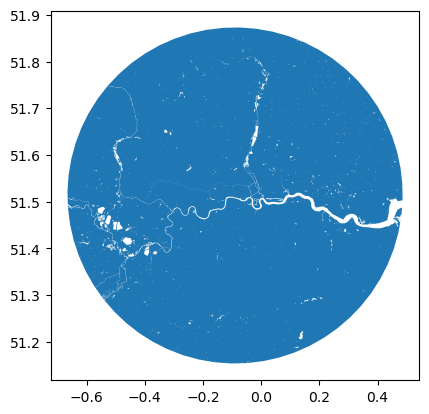

In [ ]:
buffer.plot()

In [ ]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in buffer.columns if col != 'geometry']

# Drop these columns
buffer = buffer.drop(columns=columns_to_drop)

In [ ]:
buffer_new = buffer.dissolve()

In [ ]:
buffer_new.to_parquet(f"./output/{place}/study_area.pq")

In [ ]:
osm_graph= ox.graph.graph_from_polygon(buffer_new.geometry[0], network_type='drive')
osm_graph = ox.projection.project_graph(osm_graph, to_crs=local_crs)
streets = ox.graph_to_gdfs(
    ox.get_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
    
)

streets.head()

osmid  oneway          name  \
u         v         key                                                  
105122    684418452 0                  651852806   False  Wickham Road   
          280610836 0                   25732787   False  Lloyd Villas   
          98208092  0    [338121120, 1069315449]   False  Wickham Road   
          98207597  0                   11023415    True  Lewisham Way   
684418452 684418625 0     [1069315450, 54268813]    True  Wickham Road   

                             highway maxspeed reversed   length       from  \
u         v         key                                                      
105122    684418452 0       tertiary   20 mph     True    4.639  684418452   
          280610836 0    residential   20 mph     True  153.314  280610836   
          98208092  0       tertiary   20 mph    False   73.669   98208092   
          98207597  0    residential   20 mph    False  102.410   98207597   
684418452 684418625 0       tertiary   20 mph    False   30.596  684418452   

                                to  \
u         v         key              
105122    684418452 0       105122   
          280610836 0       105122   
          98208092  0       105122   
          98207597  0       105122   
684418452 684418625 0    684418625   

                                                                  geometry  \
u         v         key                                                      
105122    684418452 0    LINESTRING (537048.850 176357.037, 537047.230 ...   
          280610836 0    LINESTRING (537155.683 176246.434, 537139.780 ...   
          98208092  0    LINESTRING (537020.586 176283.944, 537038.111 ...   
          98207597  0    LINESTRING (536981.556 176431.451, 537040.634 ...   
684418452 684418625 0    LINESTRING (537048.850 176357.037, 537049.343 ...   

                         ref lanes tunnel bridge junction access service  \
u         v         key                                                    
105122    684418452 0    NaN   NaN    NaN    NaN      NaN    NaN     NaN   
          280610836 0    NaN   NaN    NaN    NaN      NaN    NaN     NaN   
          98208092  0    NaN   NaN    NaN    NaN      NaN    NaN     NaN   
          98207597  0    NaN   NaN    NaN    NaN      NaN    NaN     NaN   
684418452 684418625 0    NaN   NaN    NaN    NaN      NaN    NaN     NaN   

                        width est_width area  
u         v         key                       
105122    684418452 0     NaN       NaN  NaN  
          280610836 0     NaN       NaN  NaN  
          98208092  0     NaN       NaN  NaN  
          98207597  0     NaN       NaN  NaN  
684418452 684418625 0     NaN       NaN  NaN

In [ ]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in streets.columns if col != 'geometry']

# Drop these columns
streets = streets.drop(columns=columns_to_drop)

In [ ]:
# Assuming your GeoDataFrame is named 'gdf'
line_strings = []
for geometry in streets.geometry:
    if geometry.geom_type == 'LineString':
        line_strings.append(geometry)
    elif geometry.geom_type == 'MultiLineString':
        line_strings.extend(list(geometry))

In [ ]:
collection = shapely.GeometryCollection(line_strings)  # combine to a single object
noded = shapely.node(collection)  # add missing nodes
streets_noded_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(noded), crs=local_crs)

In [ ]:
# Assuming streets is your existing GeoDataFrame

# Function to break apart MultiLineStrings
def explode_multilinestring(multilinestring):
    if isinstance(multilinestring, MultiLineString):
        return list(multilinestring)
    else:
        return [multilinestring]

# Explode all MultiLineStrings into individual LineStrings
exploded_lines = [explode_multilinestring(geom) for geom in streets.geometry]

# Flatten the list of lists into a single list of geometries
flat_list = [item for sublist in exploded_lines for item in sublist]

# Create a new GeoDataFrame
streets_noded_gdf = gpd.GeoDataFrame(geometry=flat_list)

<Axes: >

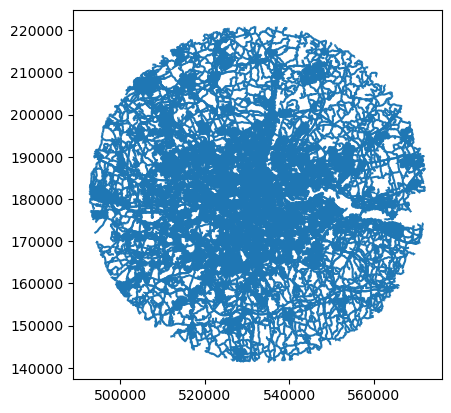

In [ ]:
streets_noded_gdf.plot()

In [ ]:
streets_noded_gdf = streets_noded_gdf.set_crs(local_crs)

In [ ]:
osm_graph= ox.graph.graph_from_polygon(buffer_new.geometry[0], network_type='all', custom_filter='["railway"~"rail"]["tunnel"!="yes"]')
osm_graph = ox.projection.project_graph(osm_graph, to_crs=local_crs)
rail = ox.graph_to_gdfs(
    ox.get_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
    
)

rail.head()



osmid maxspeed    service  oneway  \
u          v          key                                                       
1764573184 1760726884 0                 164862332   15 mph  crossover   False   
           21619626   0                  27959761   60 mph        NaN   False   
           105924518  0                  27959761   60 mph        NaN   False   
1760726884 1760726842 0    [164862322, 164434940]   60 mph        NaN   False   
           1764573202 0                 164862322   60 mph        NaN   False   

                          reversed   length        from          to  \
u          v          key                                             
1764573184 1760726884 0      False   32.734  1760726884  1764573184   
           21619626   0       True  224.540    21619626  1764573184   
           105924518  0      False  256.607   105924518  1764573184   
1760726884 1760726842 0       True  223.253  1760726842  1760726884   
           1764573202 0      False  257.104  1764573202  1760726884   

                                                                    geometry  \
u          v          key                                                      
1764573184 1760726884 0    LINESTRING (532414.753 175882.907, 532442.575 ...   
           21619626   0    LINESTRING (532642.778 176003.125, 532618.360 ...   
           105924518  0    LINESTRING (532208.967 175792.931, 532272.628 ...   
1760726884 1760726842 0    LINESTRING (532211.235 175790.175, 532216.293 ...   
           1764573202 0    LINESTRING (532644.200 176000.302, 532586.744 ...   

                           ref          name bridge tunnel  
u          v          key                                   
1764573184 1760726884 0    NaN           NaN    NaN    NaN  
           21619626   0    CAT  Catford Loop    NaN    NaN  
           105924518  0    CAT  Catford Loop    NaN    NaN  
1760726884 1760726842 0    CAT  Catford Loop    NaN    NaN  
           1764573202 0    CAT  Catford Loop    NaN    NaN

In [ ]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in rail.columns if col != 'geometry']

# Drop these columns
rail = rail.drop(columns=columns_to_drop).reset_index(drop=True)

In [ ]:
# Assuming your GeoDataFrame is named 'gdf'
rail_strings = []
for geometry in rail.geometry:
    if geometry.geom_type == 'LineString':
        rail_strings.append(geometry)
    elif geometry.geom_type == 'MultiLineString':
        rail_strings.extend(list(geometry))

In [ ]:
collection = shapely.GeometryCollection(rail_strings)  # combine to a single object
noded = shapely.node(collection)  # add missing nodes
rail_noded_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(noded), crs=local_crs)

<Axes: >

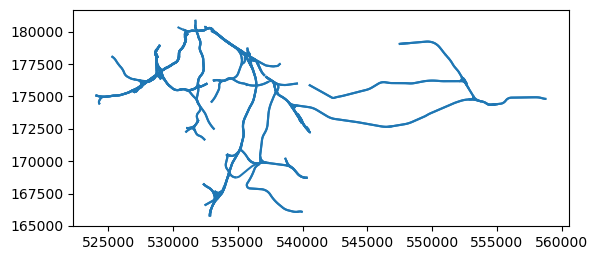

In [ ]:
rail_noded_gdf.plot()

In [ ]:
buildings

,geometry,meanHeight,RegionName,quadkey,index_right
0,"POLYGON ((-0.22656 51.76317, -0.22661 51.76329...",-1.0,UnitedKingdom,31313113,0
1,"POLYGON ((-0.09686 51.63213, -0.09676 51.63212...",-1.0,UnitedKingdom,31313113,0
5,"POLYGON ((-0.15839 51.63362, -0.15820 51.63365...",-1.0,UnitedKingdom,31313113,0
7,"POLYGON ((-0.10890 51.62402, -0.10890 51.62404...",-1.0,UnitedKingdom,31313113,0
8,"POLYGON ((-0.34290 51.63737, -0.34293 51.63746...",-1.0,UnitedKingdom,31313113,0
...,...,...,...,...,...
235144,"POLYGON ((0.05652 51.17836, 0.05658 51.17846, ...",-1.0,UnitedKingdom,120202022,0
235219,"POLYGON ((0.00662 51.16216, 0.00661 51.16230, ...",-1.0,UnitedKingdom,120202022,0
235531,"POLYGON ((0.03880 51.17923, 0.03879 51.17925, ...",-1.0,UnitedKingdom,120202022,0
236021,"POLYGON ((0.00575 51.15908, 0.00558 51.15909, ...",-1.0,UnitedKingdom,120202022,0


In [ ]:
buildings = buildings[["geometry"]]

In [ ]:
buildings = gpd.sjoin(buildings, buffer_new, how="left", op="within")

/home/virgilxw/miniconda3/envs/morph_model_v1/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [ ]:
buildings = buildings[buildings["index_right"] == 0][["geometry"]]

In [ ]:
buildings.to_parquet(f"./output/{place}/buildings_raw.pq")

streets_noded_gdf.to_parquet(f"./output/{place}/streets_raw.pq")

rail_noded_gdf.to_parquet(f"./output/{place}/rail_raw.pq")

<Axes: >

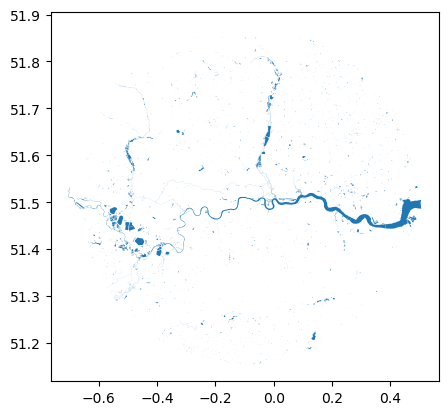

In [ ]:
water_gdf.plot()

In [ ]:
water_gdf.to_parquet(f"./output/{place}/water.pq")